# LSTM을 활용한 로또번호 예측
##  모인활 6조(오준석, 김종현, 김영지)

### *프로젝트 시작 계기
많은 사람들이 복권을 사서 일확천금을 노리는데 과연 복권에 당첨되는게 운인지, 규칙이 숨어있어 딥러닝이 복권 예측에서 좋은 성과를 낼 수 있는지 알아보고 싶습니다. 강의에서 배웠던 머신러닝을 일상생활과 가까운 문제인 복권에 적용해보고 싶다는 생각이 들어서 이 주제를 선택하게 되었습니다.


### *프로젝트 개요
- 데이터를 어떻게 가져오고 처리할 것인가?

    동행 복권사이트에서 911회의 복권 당첨 결과를 확인 할 수 있습니다.
    웹크롤링을 통하여 https://www.dhlottery.co.kr/gameResult.do?method=byWin - 마지막 회차
    https://www.dhlottery.co.kr/gameResult.do?method=byWin&drwNo= - 임의의 회차
    에서 정보들을 가져온 후 이 정보를 가지고 csv 파일로 만들어 처리합니다.


- 왜 특정 ML 알고리즘으로 해결하려는가?
LSTM을 사용하려고 합니다. 복권은 복원 추출이기 때문에 시간과 관련이 없다고 알고 있습니다. 하지만 만약에 규칙이 있다고 가정하면 시간의 흐름에 따라 규칙이 존재할 것 입니다. 따라서 시계열 데이터에 대해서 좋은 성과를 내는 LSTM을 사용하려고 합니다.


### *기대효과
- 과연 로또에는 머신러닝을 통하여 당첨확률을 높일 수 있는지 알 수 있습니다.
- 예측에 실패한 경우 로또에 규칙이 존재하지 않는다는 것을 증명할 수 있습니다.
------------------------------------
------------------------------------

## 들어가기 전에...

* 로또 같은 독립시행(매 시행마다 특정 결과가 나올 확률이 변하지 않는 것)확률을 가지는 것에는 예측 모델이 의미가 없을 수도 있지만,
  저희가 테스트 할 모델은 종속시행 (이전의 시행 결과가 현재의 확률에 영향을 줌)을 전제로 합니다.



* 예측 모델을 어떻게 개발했던 간에 이미 913회라는 결과가 있으니 검증을 해볼 수는 있습니다. 이 검증 방법에 대해서는 논리적인지 합리적인지 논의해볼 가치가 있다고 봅니다.

### 문제정의
데이터를 모았으니 이제 문제정의 먼저 해보겠습니다. 문제정의에 따라 데이터셋과 모델 구성이 달라지니 신중하게 생각할 부분입니다.

__'문제정의에 따라 데이터셋과 모델 구성이 달라진다.'__

#### - 데이터셋 구성

913회차의 빅데이터로 모델에 학습시키기 위한 데이터셋을 구성

두가지 전제가 존재.

- 첫번째 전제: 저희가 실험할 모델의 전제는 “로또 번호는 과거부터 미래까지 이미 정해져 있다” 입니다. 즉, 지금까지 외운 로또번호를 가지고 과거로 가면 모두 1등이 될 수 있고, 미래에 다녀와서 본 로또 번호를 이번에 제출하면 당첨이 될 수 있다는 것입니다.

- 두번째 전제: 지금까지의 로또번호를 딥러닝에게 외우게 하면 딥러닝이 뭔가 원리를 깨달아서 그 원리대로 그 다음회 로또번호를 예측할 수 있다는 것입니다.

두번째 전제인 경우에는 마치 원주율을 어느 소수점짜리까지 학습하면, 그 다음 자리수를 예측한다는 것과 비슷한 얘기입니다. 원주율은 순환하지 않은 무한소수인데요. 원주율이 아래와 같다고 했을 때,

3.14159265358979323846264338327950288419...

아래와 같이 이전 수들로 다음 수를 예측하게 학습시킨 뒤, 마지막 수의 다음을 예측하도록 하는 것입니다.

학습과정

* 3 > 1

* 3.1 > 4

* 3.14 > 1

* 3.141 > 5

* …

* 3.141592653589793238462643383279502884 > 1

추론과정

3.1415926535897932384626433832795028841 > 9(희망)

물론, 이것이 불가능해 보이지만, 로또가 아닌 규칙이 있는 시계열 데이터인 경우에는 해볼만한 모델이라고 볼 수 있다.



### 데이터 수집
전제에서 보면, 결국 과거의 로또 번호로 미래의 번호를 예측하는 것이기에 과거의 로또 번호를 수집해야 합니다. 동행복권 웹페이지에서 당첨된 번호를 알 수 있는데요, 일일이 기록하기가 쉽지 않으니 파이썬 프로그램을 간단히 짜서 자동으로 수집하겠습니다. 이를 “웹 크롤링”이라고 부릅니다. 

In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup

main_url = "https://www.dhlottery.co.kr/gameResult.do?method=byWin" # 마지막 회차를 얻기 위한 주소
basic_url = "https://www.dhlottery.co.kr/gameResult.do?method=byWin&drwNo=" # 임의의 회차를 얻기 위한 주소

# 마지막 회차 정보를 가져옴
def GetLast(): 
    resp = requests.get(main_url)
    soup = BeautifulSoup(resp.text, "lxml")
    result = str(soup.find("meta", {"id" : "desc", "name" : "description"})['content'])
    s_idx = result.find(" ")
    e_idx = result.find("회")
    return int(result[s_idx + 1 : e_idx])

# 지정된 파일에 지정된 범위의 회차 정보를 기록함
def Crawler(s_count, e_count, fp):
    for i in range(s_count , e_count + 1):
        crawler_url = basic_url + str(i)
        resp = requests.get(crawler_url)
        soup = BeautifulSoup(resp.text, "html.parser")

        text = soup.text

        s_idx = text.find(" 당첨결과")
        s_idx = text.find("당첨번호", s_idx) + 4
        e_idx = text.find("보너스", s_idx)
        numbers = text[s_idx:e_idx].strip().split()

        s_idx = e_idx + 3
        e_idx = s_idx + 3
        bonus = text[s_idx:e_idx].strip()

        s_idx = text.find("1등", e_idx) + 2
        e_idx = text.find("원", s_idx) + 1
        e_idx = text.find("원", e_idx)
        money1 = text[s_idx:e_idx].strip().replace(',','').split()[2]

        s_idx = text.find("2등", e_idx) + 2
        e_idx = text.find("원", s_idx) + 1
        e_idx = text.find("원", e_idx)
        money2 = text[s_idx:e_idx].strip().replace(',','').split()[2]

        s_idx = text.find("3등", e_idx) + 2
        e_idx = text.find("원", s_idx) + 1
        e_idx = text.find("원", e_idx)
        money3 = text[s_idx:e_idx].strip().replace(',','').split()[2]

        s_idx = text.find("4등", e_idx) + 2
        e_idx = text.find("원", s_idx) + 1
        e_idx = text.find("원", e_idx)
        money4 = text[s_idx:e_idx].strip().replace(',','').split()[2]

        s_idx = text.find("5등", e_idx) + 2
        e_idx = text.find("원", s_idx) + 1
        e_idx = text.find("원", e_idx)
        money5 = text[s_idx:e_idx].strip().replace(',','').split()[2]

        line = str(i) + ',' + numbers[0] + ',' + numbers[1] + ',' + numbers[2] + ',' + numbers[3] + ',' + numbers[4] + ',' + numbers[5] + ',' + bonus + ',' + money1 + ',' + money2 + ',' + money3 + ',' + money4 + ',' + money5
        print(line)
        line += '\n'
        fp.write(line)

last = GetLast() # 마지막 회차를 가져옴

fp = open('2020-1-25-keras_lstm_lotto_v895_data.csv', 'w')
Crawler(1, last, fp) # 처음부터 마지막 회차까지 저장
fp.close()

1,10,23,29,33,37,40,16,0,143934100,5140500,113400,10000
2,9,13,21,25,32,42,2,2002006800,94866800,1842000,100800,10000
3,11,16,19,21,27,31,30,2000000000,0,1174100,54900,10000
4,14,27,30,31,40,42,2,0,211191200,7282400,152100,10000
5,16,24,29,40,41,42,3,0,0,6033800,166500,10000
6,14,15,26,27,40,42,34,6574451700,196297600,4267300,87600,10000
7,2,9,16,25,26,40,42,0,48165000,1605500,65500,10000
8,8,19,25,34,37,39,9,0,131555000,2268100,110500,10000
9,2,4,16,17,36,39,14,0,769456500,8743800,260000,10000
10,9,25,30,33,41,44,6,6430437900,40813400,856400,27300,10000
11,1,7,36,37,41,42,14,4780152300,362132700,9307100,206800,10000
12,2,11,21,25,39,45,44,1348845700,99914400,1417500,70200,10000
13,22,23,25,37,38,42,26,0,433309300,5777400,175600,10000
14,2,6,12,31,33,40,15,9375048300,130363400,2568700,93900,10000
15,3,4,16,30,31,37,13,17014245000,177231700,5571100,144600,10000
16,6,7,24,37,38,40,33,4377146100,243174700,3385200,123500,10000
17,3,4,9,17,32,37,1,5349491200,297193900,2342100,86700,10000
18


지금까지 나온 1회~913회의 번호를 기록한 파일을 열어보면 위의 결과값 같이 각 회차마다 한 행으로 되어 있고, 각 열은 쉼표로 구분되어 있습니다.

각 열의 의미는 다음과 같습니다.


* 회차

* 첫번째 당첨번호

* 두번째 당첨번호

* 세번째 당첨번호

* 네번째 당첨번호

* 다섯번째 당첨번호

* 여섯번째 당첨번호

* 보너스 번호

* 1등 당첨금액

* 2등 당첨금액

* 3등 당첨금액

* 4등 당첨금액

* 5등 당첨금액

----------------------------------------------------------------------------------

### 문제정의
- 데이터를 모았으니 이제 문제정의 먼저 해보겠습니다. 문제정의에 따라 데이터셋과 모델 구성이 달라지므로 매우 중요합니다.

    "문제정의에 따라 데이터셋과 모델 구성이 달라진다."

### 번호를 범주형으로

먼저 로또 번호에 대해서 살펴보겠습니다. 총 45개 번호 중에 6개 번호를 고르는 것입니다. 이런 용지에다가 사인펜으로 마킹을 하게 됩니다.


<img src="keras_lstm_lotto_v895_img1.png" width="600">


45개 번호라고 함은 1번에서 45번을 얘기하는데, 각 번호들이 수치상의 의미가 있을까요? 또는 숫자들의 위치가 의미가 있을까요? 이것은 그냥 번호일뿐이지 수치나 위치상의 의미는 없어보입니다. 이를 어려운 단어로 “범주형 데이터”라고 합니다. 이런 범주형 데이터를 다루는 데 일반적으로 사용되는 기법이 “원핫인코딩”이 있습니다. 만약 1번에서 5번까지만 있다고 가정을 한다면 원핫인코딩은 각 번호를 아래와 같이 만듭니다.

1 : 10000

2 : 01000

3 : 00100

4 : 00010

5 : 00001

경우의 수만큼 0값을 가진 벡터를 만든다음 해당 자리수에 1로 설정하면 됩니다. 로또 번호인 경우에는 경우의 수가 45개이므로 아래와 같습니다.

01 : 100000000000000000000000000000000000000000000

02 : 010000000000000000000000000000000000000000000

03 : 001000000000000000000000000000000000000000000

…

44 : 000000000000000000000000000000000000000000010

45 : 000000000000000000000000000000000000000000001

이렇게 구성하면 이제 로또 번호는 수치상의 의미를 가지는 것이 아닌 45개 경우의 수 중 하나인 클래스(범주)로 다루게 됩니다.



### 모델의 입출력 정의
모델 입출력은 간단합니다. 이전 회차의 당첨번호를 넣어서 다음회차의 당첨번호를 예측하는 것입니다.

#### * 이전회차 당첨번호 > |모델| > 다음회차 당첨번호 예측

이전회차 당첨번호를 표현하고 싶다면, 45개 번호 중 6개가 당첨번호이니, 45개의 벡터를 만들고 0으로 초기화한 뒤 이 중 당첨번호에 해당하는 벡터만 1로 설정하도록 해야합니다. “벡터”의 개념은 그냥 “빈칸”이라고 생각하고 “45개 벡터”는 “45개 빈칸”이라고 이해하면 됩니다. 따라서 만약 이전회차 당첨번호가 “1,2,3,4,5,6”이라면 아래와 같이 벡터로 표시할 수 있습니다.

1,2,3,4,5,6 : 111111000000000000000000000000000000000000000

45개의 빈칸에 1로 사인펜으로 마킹하는 것과 흡사합니다. 이를 함수로 만들면 아래와 같습니다. 원핫인코딩 값을 쉽게 확인 할 수 있도록 원핫인코딩을 번호로 변환하는 함수도 추가합니다.

In [2]:
import numpy as np

# 당첨번호를 원핫인코딩벡터(ohbin)으로 변환
def numbers2ohbin(numbers):

    ohbin = np.zeros(45) #45개의 빈 칸을 만듬

    for i in range(6): #여섯개의 당첨번호에 대해서 반복함
        ohbin[int(numbers[i])-1] = 1 #로또번호가 1부터 시작하지만 벡터의 인덱스 시작은 0부터 시작하므로 1을 뺌
    
    return ohbin

# 원핫인코딩벡터(ohbin)를 번호로 변환
def ohbin2numbers(ohbin):

    numbers = []
    
    for i in range(len(ohbin)):
        if ohbin[i] == 1.0: # 1.0으로 설정되어 있으면 해당 번호를 반환값에 추가한다.
            numbers.append(i+1)
    
    return numbers

ohbin은 one-hot encoding bin의 약자이고, bin은 범주(카테고리) 벡터를 의미하는 용어입니다.
벡터는 쉽게 배열로 생각하면 되는데, 배열의 인덱스는 항상 0부터 시작합니다.
보너스 번호는 고려하지 않았습니다.

출력 또한 입력과 비슷하게 원핫인코딩 형태로 만듭니다. 그럼 실제 1회와 2회차를 예를 들어, 1회 당첨번호를 모델에 입력하면, 모델에서 2회 당첨번호를 알려준다고 가정을 해보겠습니다. 먼저 1회, 2회차 당첨번호를 numbers2ohbin() 함수를 이용해서 ohbin으로 변환해봅니다.

In [3]:
print("1:" + str(numbers2ohbin([10,23,29,33,37,40])))
print("2:" + str(numbers2ohbin([9,13,21,25,32,42])))

1:[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0.]
2:[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


즉, 아래처럼 1회차의 ohbin을 넣으면 2회차의 ohbin가 나오길 희망하는 것입니다.

000000000100000000000010000010001000100100000 > |모델| > 000000001000100000001000100000010000000001000


계속해서 n회차에서도 ohbin을 얻어서 n+1회차의 ohbin가 나오게 합니다. 

### 샘플의 구성

샘플이라고 함은 지도학습에서 하나의 문제(X)와 정답(Y)의 한 쌍을 의미한다고 할 수 있습니다. 따라서 이 경우 지도학습 모델의 입력이 문제가 되고, 모델의 출력이 정답이 됩니다. 샘플을 (X, Y)으로 표현했을 때, 우리가 만들 수 있는 샘플의 수는 총 912개입니다.

(1회차 당첨번호, 2회차 당첨번호)

(2회차 당첨번호, 3회차 당첨번호)

(3회차 당첨번호, 4회차 당첨번호) …

(911회차 당첨번호, 912회차 당첨번호)

(912회차 당첨번호, 913회차 당첨번호)

앞서 수집한 데이터로부터 X와 Y로 구성된 샘플을 구성해보겠습니다. 먼저 파일을 로딩합니다. 1회차부터 913회차까지 있으므로 총 913개의 행이 존재함을 확인할 수 있습니다.

In [4]:
rows = np.loadtxt("./2020-1-25-keras_lstm_lotto_v895_data.csv", delimiter=",")
row_count = len(rows)

print("row count: " + str(row_count))

row count: 913


각 행에서 당첨번호만 추출하여 이를 원핫인코딩으로 변환한 뒤 앞서 언급한 샘플(X, Y)로 구성합니다. 샘플 중 가장 첫번째 샘플인 X가 1회차 당첨번호이고, Y가 2회차 당첨번호인 것만 확인해보겠습니다.

In [5]:
numbers = rows[:, 1:7]
ohbins = list(map(numbers2ohbin, numbers))

x_samples = ohbins[0:row_count-1]
y_samples = ohbins[1:row_count]

#원핫인코딩으로 표시
print("ohbins")
print("X[0]: " + str(x_samples[0]))
print("Y[0]: " + str(y_samples[0]))

#번호로 표시
print("numbers")
print("X[0]: " + str(ohbin2numbers(x_samples[0])))
print("Y[0]: " + str(ohbin2numbers(y_samples[0])))

ohbins
X[0]: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0.]
Y[0]: [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
numbers
X[0]: [10, 23, 29, 33, 37, 40]
Y[0]: [9, 13, 21, 25, 32, 42]


### 데이터셋 구성

샘플로부터 데이터셋 구성을 “훈련셋/검증셋/시험셋”으로 나누어보겠습니다.

- 훈련셋: (1회 입력, 2회 출력)부터 (700회 입력, 701회)까지 700개 샘플
- 검증셋: (701회, 702회)부터 (800회, 801회)까지 100개 샘플
- 시험셋: (801회, 802회)부터 (912회, 913회)까지 112개 샘플

이렇게 나누는 기준은 딱히 정해진 것은 없지만 데이터수가 적으므로 위와 같이 지정했습니다.

In [6]:
train_idx = (0, 700)
val_idx = (700, 800)
test_idx = (800, len(x_samples))

print("train: {0}, val: {1}, test: {2}".format(train_idx, val_idx, test_idx))

train: (0, 700), val: (700, 800), test: (800, 912)


### 모델 구성

모델을 딥러닝 라이브러리 중 하나인 텐서플로우 2.0의 케라스를 이용합니다. 

(구글 코랩에서 시작하시는 분은 아래 명령을 통해서 텐서플로우 2.0을 설치합니다.)

In [7]:
from __future__ import absolute_import, division, print_function, unicode_literals
!pip install tensorflow-gpu==2.0.0-rc1

모델은 간단하게 상태유지 LSTM 모델로 구성하고 몇가지 특징을 나열해보았습니다.

* 타입스텝은 1인 대신, 상태유지(stateful 옵션을 True)으로 설정했습니다.
* 45개의 벡터로 출력합니다.
* 각각의 벡터는 0.0과 1.0사이의 실수값으로 나옵니다. 각 벡터가 독립적으로 모두 1.0이 나오거나 0.0이 나올 수 있는 멀티레이블 문제입니다.
* 멀티레이블 문제라 출력층의 활성화함수가 softmax가 아닌 sigmoid로 설정하였습니다.


In [8]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models

# 모델을 정의합니다.
model = keras.Sequential([
    keras.layers.LSTM(128, batch_input_shape=(1, 1, 45), return_sequences=False, stateful=True),
    keras.layers.Dense(45, activation='sigmoid')
])

# 모델을 컴파일합니다.
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

### 모델 학습
모델 컴파일까지 완료했다면 훈련셋으로 모델을 학습시킵니다. 모델을 학습시키는 코드는 “model.train_on_batch()” 코드 한 줄이지만 학습과정을 살펴보는 것이 중요하므로 부가 코드들을 삽입해 보았습니다. 또한 과적합이 일어나지 않은 최적의 학습 모델을 얻는 것이 목표이므로 매 에포크마다 학습된 모델을 파일로 저장하는 코드도 삽입되어 있습니다.


In [10]:
# 매 에포크마다 훈련과 검증의 손실 및 정확도를 기록하기 위한 변수
train_loss = []
train_acc = []
val_loss = []
val_acc = []

# 최대 100번 에포크까지 수행
for epoch in range(100):

    model.reset_states() # 중요! 매 에포크마다 1회부터 다시 훈련하므로 상태 초기화 필요

    batch_train_loss = []
    batch_train_acc = []
    
    for i in range(train_idx[0], train_idx[1]):
        
        xs = x_samples[i].reshape(1, 1, 45)
        ys = y_samples[i].reshape(1, 45)
        
        loss, acc = model.train_on_batch(xs, ys) #배치만큼 모델에 학습시킴

        batch_train_loss.append(loss)
        batch_train_acc.append(acc)

    train_loss.append(np.mean(batch_train_loss))
    train_acc.append(np.mean(batch_train_acc))

    batch_val_loss = []
    batch_val_acc = []

    for i in range(val_idx[0], val_idx[1]):

        xs = x_samples[i].reshape(1, 1, 45)
        ys = y_samples[i].reshape(1, 45)
        
        loss, acc = model.test_on_batch(xs, ys) #배치만큼 모델에 입력하여 나온 답을 정답과 비교함
        
        batch_val_loss.append(loss)
        batch_val_acc.append(acc)

    val_loss.append(np.mean(batch_val_loss))
    val_acc.append(np.mean(batch_val_acc))

    print('epoch {0:4d} train acc {1:0.3f} loss {2:0.3f} val acc {3:0.3f} loss {4:0.3f}'.format(epoch, np.mean(batch_train_acc), np.mean(batch_train_loss), np.mean(batch_val_acc), np.mean(batch_val_loss)))

    model.save('model_{0:04d}.h5'.format(epoch+1))

epoch    0 train acc 0.867 loss 0.392 val acc 0.867 loss 0.396
epoch    1 train acc 0.867 loss 0.389 val acc 0.867 loss 0.398
epoch    2 train acc 0.867 loss 0.384 val acc 0.867 loss 0.400
epoch    3 train acc 0.867 loss 0.377 val acc 0.867 loss 0.402
epoch    4 train acc 0.867 loss 0.371 val acc 0.866 loss 0.406
epoch    5 train acc 0.867 loss 0.364 val acc 0.867 loss 0.409
epoch    6 train acc 0.867 loss 0.358 val acc 0.866 loss 0.413
epoch    7 train acc 0.868 loss 0.351 val acc 0.865 loss 0.416
epoch    8 train acc 0.868 loss 0.344 val acc 0.864 loss 0.421
epoch    9 train acc 0.869 loss 0.336 val acc 0.862 loss 0.426
epoch   10 train acc 0.871 loss 0.328 val acc 0.861 loss 0.431
epoch   11 train acc 0.873 loss 0.319 val acc 0.859 loss 0.438
epoch   12 train acc 0.874 loss 0.310 val acc 0.857 loss 0.443
epoch   13 train acc 0.876 loss 0.300 val acc 0.853 loss 0.448
epoch   14 train acc 0.880 loss 0.289 val acc 0.851 loss 0.456
epoch   15 train acc 0.885 loss 0.278 val acc 0.848 los

### 모델 학습 과정 살펴보기

매 에포크마다 저장된 훈련셋의 손실값 및 정확도와 검증셋의 손실값 및 정확도에 대해서 기록한 것을 그래프로 표현해봤습니다.

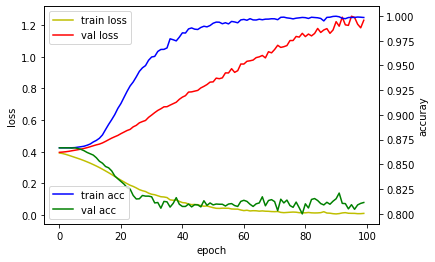

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(train_loss, 'y', label='train loss')
loss_ax.plot(val_loss, 'r', label='val loss')

acc_ax.plot(train_acc, 'b', label='train acc')
acc_ax.plot(val_acc, 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

정상적으로 학습할 수 있는 일반적인 데이터셋과 모델이라면 val loss(빨간색)이 떨어지다가 다시 올라가는 것이 정상입니다. 즉, 훈련을 하면서 검증셋에 대해서도 잘 맞추다가 어느정도 훈련이 진행되면 검증셋의 손실값(val loss)를 다시 올라갑니다. 이 시점을 과적합(오버피팅)이 되었다고 하고, 이 시점 이전의 저장된 모델을 사용하는 것이 일반적입니다.

하지만, 보시다시피 학습이 시작하자마자 검증셋의 손실값이 올라갑니다. 이 말은 처음에 그냥 랜덤인 상태가 차라리 더 좋다는 것이고 학습이 진행되면 바로 오버피팅이 일어나서 오히려 결과가 더 좋지 않다는 것을 의미합니다. 

이 그래프를 통해, 로또는 독립시행이라 이전 번호로 학습하는 것이 무의미하다는 것을 알 수 있습니다. 

사실, 이 그래프로 인하여 이후의 과정은 무의미할 수 있겠지만, 결과값을 통하여 로또의 예측확률 모델의 분석도를 높이도록 하겠습니다. 

### 모델 검증
모델을 검증하는 방법은 여러가지가 있을 수 있습니다. 1등 당첨번호를 잘 맞추는 것도 중요하지만 로또 시스템은 등수별로 차등으로 상금이 주어지기 때문에 등수가 낮더라도 상금을 타는 확률을 높이는 것이 더 좋을 수도 있습니다. 학습한 모델을 등수와 상금 관점에서 얼마나 잘 맞는 지 검증을 해보도록 하겠습니다.
### 메트릭 추가
지난 회차인 경우 각 회차마다 등수별 상금이 정해져 있긴 하지만 1등이 나오지 않는 결측치도 있고, 87회차 이전까지는 한 판의 가격이 2천원이어서 이를 아래와 같이 간소화 시켰습니다.

* 한 판의 가격은 1천원입니다

* 88회차부터 지금까지 1등부터 5등까지의 등수별로 평균을 냅니다

In [12]:
# 88회부터 지금까지 1등부터 5등까지 상금의 평균을 낸다.
mean_prize = [  np.mean(rows[87:, 8]),
                np.mean(rows[87:, 9]),
                np.mean(rows[87:, 10]),
                np.mean(rows[87:, 11]),
                np.mean(rows[87:, 12])]

print(mean_prize)          

[2431677835.4661016, 57214080.22397094, 1451755.1186440678, 52991.498789346246, 5000.0]


그리고 예측한 번호를 당첨번호와 보너스번호와 함께 입력하면 등수 및 평균 상금을 반환해주는 함수가 필요하게 됩니다.

In [13]:
# 등수와 상금을 반환함
# 순위에 오르지 못한 경우에는 등수가 0으로 반환함
def calc_reward(true_numbers, true_bonus, pred_numbers):

    count = 0

    for ps in pred_numbers:
        if ps in true_numbers:
            count += 1

    if count == 6:
        return 0, mean_prize[0]
    elif count == 5 and true_bonus in pred_numbers:
        return 1, mean_prize[1]
    elif count == 5:
        return 2, mean_prize[2]
    elif count == 4:
        return 3, mean_prize[3]
    elif count == 3:
        return 4, mean_prize[4]

    return 5, 0

즉 모델을 검증하기 위해 두 가지 메트릭을 추가한 셈입니다. 즉 이는 다음의 의미를 내포하고 있습니다.

"당첨번호를 맞추는 것도 중요하지만 몇 등인지, 상금이 얼마인지도 중요하다"

그럼 실제 로또 번호를 생성해보도록 합니다. 모델 출력은 45개의 0.0과 1.0사이의 값으로 나오는 1차원 벡터입니다. 각 번호에 할당된 벡터의 값이 1.0에 가까울수록 모델이 생각하기에 당첨확률이 높은 번호이고 0.0에 가까울수록 당첨확률이 낮은 번호입니다. 따라서 모델 출력에서 가장 확률값이 높은 6개의 벡터를 구하면 그것이 모델이 예측하는 당첨번호라고 볼 수 있습니다. 모델 출력으로부터 번호를 생성하는 방식은 다음과 같습니다.

1. 45개의 벡터마다 출력값을 가져온다 
2. 각 벡터의 출력값은 0.0에서 1.0이다 
3. 각 벡터마다 벡터의 출력값에 100을 곱한 뒤 1을 더한 값만큼의 수만큼 해당 번호의 공을 만든다 

    ex) 
    - 0번째 벡터(번호 1번)의 값이 0.2이었다면, 1번 공을 21개(0.2100+1) 만든다. 
    - 7번째 벡터(번호 8번)의 값이 0.0이었다면, 8번 공을 1개(0.0100+1) 만든다. 
    - 40번째 벡터(번호 41번)의 값이 0.99이었다면, 41번 공을 100개(0.99100+1) 만든다. 
    
    
4. 만든 공을 큰 박스에 담는다.
5. 박스에서 하나를 고른 후 다시 박스에 담는다.
6. 고른 번호가 이전에 고른 번호가 아니라면 추천번호로 저장한다. 만약 이미 고른 번호라면 다시 하나를 고른 뒤 박스에 담는다. 
7. 추천번호가 6개가 될 때까지 위 과정을 반복한다.

이런 식으로 번호를 생성하면, 모델의 해당 번호의 벡터 출력값이 높을 수록 그 번호의 공의 개수가 늘어납니다. 특정 번호의 공 개수가 많다고 해서 반드시 박스에서 뽑히지는 않고, 또한 공의 개수가 하나라고 안 뽑히는 것도 아니므로 적당히 10개의 로또 번호가 다르게 나올 수 있습니다. 이렇게 번호를 뽑는 함수를 “gen_numbers_from_probability()”으로 만들어봤습니다.

In [14]:
def gen_numbers_from_probability(nums_prob):

    ball_box = []

    for n in range(45):
        ball_count = int(nums_prob[n] * 100 + 1)
        ball = np.full((ball_count), n+1) #1부터 시작
        ball_box += list(ball)

    selected_balls = []

    while True:
        
        if len(selected_balls) == 6:
            break
        
        ball_index = np.random.randint(len(ball_box), size=1)[0]
        ball = ball_box[ball_index]

        if ball not in selected_balls:
            selected_balls.append(ball)

    return selected_balls

이제 학습한 모델도 있고, 모델 결과로부터 번호를 생성하는 함수도 있고, 그렇게 생성한 번호로부터 등수와 상금을 계산하는 함수도 있습니다. 그럼 실험을 해보겠습니다.

실험은 입력을 1회차부터 912회차까지 해보겠습니다. 즉

1회차 당첨번호를 모델에 입력한 후 모델 출력으로부터 10판의 번호를 생성한 뒤 2회차와 비교하여 등수와 상금 계산

2회차 당첨번호를 모델에 입력한 후 모델 출력으로부터 10판의 번호를 생성한 뒤 3회차와 비교하여 등수와 상금 계산

…

912회차 당첨번호를 모델에 입력한 후 모델 출력으로부터 10판의 번호를 생성한 뒤 913회차와 비교하여 등수와 상금 계산

모델을 1회차부터 다시 추론을 해야하므로 상태 초기화부터 시작합니다. 실험 코드는 아래와 같습니다.



In [15]:
train_total_reward = []
train_total_grade = np.zeros(6, dtype=int)

val_total_reward = []
val_total_grade = np.zeros(6, dtype=int)

test_total_reward = []
test_total_grade = np.zeros(6, dtype=int)

model.reset_states()

print('[No. ] 1st 2nd 3rd 4th 5th 6th Rewards')

for i in range(len(x_samples)):
    xs = x_samples[i].reshape(1, 1, 45)
    ys_pred = model.predict_on_batch(xs) # 모델의 출력값을 얻음
    
    sum_reward = 0
    sum_grade = np.zeros(6, dtype=int) # 6등까지 변수

    for n in range(10): # 10판 수행
        numbers = gen_numbers_from_probability(ys_pred[0])
        
        #i회차 입력 후 나온 출력을 i+1회차와 비교함
        grade, reward = calc_reward(rows[i+1,1:7], rows[i+1,7], numbers) 

        sum_reward += reward
        sum_grade[grade] += 1

        if i >= train_idx[0] and i < train_idx[1]:
            train_total_grade[grade] += 1
        elif i >= val_idx[0] and i < val_idx[1]:
            val_total_grade[grade] += 1
        elif i >= test_idx[0] and i < test_idx[1]:
            val_total_grade[grade] += 1
    
    if i >= train_idx[0] and i < train_idx[1]:
        train_total_reward.append(sum_reward)
    elif i >= val_idx[0] and i < val_idx[1]:
        val_total_reward.append(sum_reward)
    elif i >= test_idx[0] and i < test_idx[1]:
        test_total_reward.append(sum_reward)
                        
    print('[{0:4d}] {1:3d} {2:3d} {3:3d} {4:3d} {5:3d} {6:3d} {7:15,d}'.format(i+1, sum_grade[0], sum_grade[1], sum_grade[2], sum_grade[3], sum_grade[4], sum_grade[5], int(sum_reward)))

print('Total') 
print('==========')    
print('Train {0:5d} {1:5d} {2:5d} {3:5d} {4:5d} {5:5d} {6:15,d}'.format(train_total_grade[0], train_total_grade[1], train_total_grade[2], train_total_grade[3], train_total_grade[4], train_total_grade[5], int(sum(train_total_reward))))
print('Val   {0:5d} {1:5d} {2:5d} {3:5d} {4:5d} {5:5d} {6:15,d}'.format(val_total_grade[0], val_total_grade[1], val_total_grade[2], val_total_grade[3], val_total_grade[4], val_total_grade[5], int(sum(val_total_reward))))
print('Test  {0:5d} {1:5d} {2:5d} {3:5d} {4:5d} {5:5d} {6:15,d}'.format(test_total_grade[0], test_total_grade[1], test_total_grade[2], test_total_grade[3], test_total_grade[4], test_total_grade[5], int(sum(test_total_reward))))
print('==========')    

[No. ] 1st 2nd 3rd 4th 5th 6th Rewards
[   1]   4   0   4   2   0   0   9,732,624,345
[   2]   4   1   5   0   0   0   9,791,184,197
[   3]   3   0   3   3   1   0   7,299,552,746
[   4]   5   0   4   1   0   0  12,164,249,189
[   5]   6   0   2   1   1   0  14,593,028,514
[   6]   5   0   4   1   0   0  12,164,249,189
[   7]   5   0   5   0   0   0  12,165,647,952
[   8]   2   0   6   2   0   0   4,872,172,184
[   9]   4   0   6   0   0   0   9,735,421,872
[  10]   5   0   5   0   0   0  12,165,647,952
[  11]   2   0   4   3   1   0   4,869,326,665
[  12]   2   0   6   1   1   0   4,872,124,193
[  13]   4   0   4   2   0   0   9,732,624,345
[  14]   2   0   3   5   0   0   4,867,975,893
[  15]   3   0   6   1   0   0   7,303,797,028
[  16]   3   0   5   1   1   0   7,302,350,273
[  17]   1   0   4   4   1   0   2,437,701,821
[  18]   5   0   5   0   0   0  12,165,647,952
[  19]   4   0   6   0   0   0   9,735,421,872
[  20]   4   0   3   3   0   0   9,731,225,581
[  21]   2   0   8   

모델의 검증은 하나의 메트릭으로만 하는 것이 아니라 여러가지 메트릭이 적용됩니다. 목적은 상금이기 때문에, 여기서는 정확도뿐만아니라 상금의 척도도 사용한 것입니다. 그럼 학습한 모델의 결과를 2회차부터 지금까지 추론하였을 때, 상금이 얼마인지 그래프로 표시해보겠습니다.

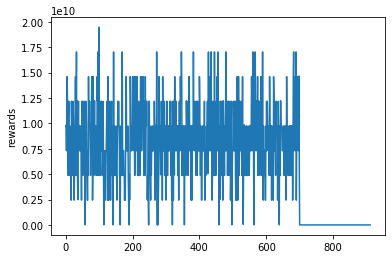

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt

total_reward = train_total_reward + val_total_reward + test_total_reward

plt.plot(total_reward)
plt.ylabel('rewards')
plt.show()

701번째부터 상금이 뚝 떨어지는 것을 볼 수 있는데, 700번째까지는 이미 학습(거의 외웠다고 볼 수 있습니다)한 것이기에 1등도 하고 2등도 하고 3등도 하지만, 학습을 하지 않은 샘플인 701번째부터는 상금이 급격히 줄어들게 됩니다. 즉, 로또는 학습해서 될 문제가 아니라는 것을 알 수 있습니다.


아래에 훈련셋, 검증셋, 시험셋으로 상금을 막대그래프로 표시해봤습니다. val과 test 상금이 train 상금보다 적기에 표시가 되지 않았습니다.

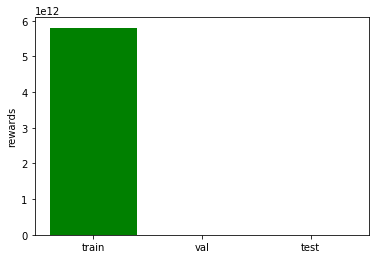

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

rewards = [sum(train_total_reward), sum(val_total_reward), sum(test_total_reward)]

class_color=['green', 'blue', 'red']

plt.bar(['train', 'val', 'test'], rewards, color=class_color)
plt.ylabel('rewards')
plt.show()

### 시계열 데이터에서의 학습과 검증

시계열 데이터에서의 학습과 검증은 데이터셋을 나누는 데에 있어서 조금 더 신경써야할 것이 있습니다.

앞서 원주율을 예를 들었는 데, 다시 보겠습니다.

학습과정
* 3 > 1
* 3.1 > 4
* 3.14 > 1
* 3.141 > 5
* …
* 3.141592653589793238462643383279502884 > 1
추론과정
* 3.1415926535897932384626433832795028841 > 9(희망)

즉 우리가 원하는 추론과정은 마지막 “9”을 추론하는 것이지 그 이상을 추론하는 것이 아닙니다. 즉 “9”를 추론하기 위에서 그 직전까지 학습시키고, 그 다음 한 스텝만 추론하면 됩니다. 하지만 우리는 앞서 아래와 같이 나누었습니다.

훈련셋: (1회 입력, 2회 출력)부터 (700회 입력, 701회 출력)까지 700개 샘플

검증셋: (701회 입력, 702회)부터 (800회 입력, 801회 출력)까지 100개 샘플

시험셋: (801회 입력, 802회)부터 (912회 입력, 913회 출력)까지 112개 샘플

즉, 검증셋과 시험셋을 추론할 때, (1회 입력, 2회 출력)부터 (700회 입력, 701회 출력)까지 700개 샘플만 학습한 것을 가지고 100개 + 112개를 추론한 것입니다. 검증하는 것이 사실상 의미가 없기에 이번에는 ___913회차까지 번호를 다 학습시키고, 마지막 914회차만 예측해보겠습니다.___

In [18]:
# 최대 100번 에포크까지 수행
for epoch in range(100):

    model.reset_states() # 중요! 매 에포크마다 1회부터 다시 훈련하므로 상태 초기화 필요

    for i in range(len(x_samples)):
        
        xs = x_samples[i].reshape(1, 1, 45)
        ys = y_samples[i].reshape(1, 45)
        
        loss, acc = model.train_on_batch(xs, ys) #배치만큼 모델에 학습시킴

        batch_train_loss.append(loss)
        batch_train_acc.append(acc)

    train_loss.append(np.mean(batch_train_loss))
    train_acc.append(np.mean(batch_train_acc))

    print('epoch {0:4d} train acc {1:0.3f} loss {2:0.3f}'.format(epoch, np.mean(batch_train_acc), np.mean(batch_train_loss)))  

epoch    0 train acc 0.971 loss 0.150
epoch    1 train acc 0.954 loss 0.195
epoch    2 train acc 0.951 loss 0.196
epoch    3 train acc 0.951 loss 0.188
epoch    4 train acc 0.953 loss 0.178
epoch    5 train acc 0.955 loss 0.168
epoch    6 train acc 0.957 loss 0.160
epoch    7 train acc 0.958 loss 0.152
epoch    8 train acc 0.960 loss 0.146
epoch    9 train acc 0.961 loss 0.139
epoch   10 train acc 0.962 loss 0.134
epoch   11 train acc 0.964 loss 0.128
epoch   12 train acc 0.965 loss 0.124
epoch   13 train acc 0.966 loss 0.119
epoch   14 train acc 0.967 loss 0.115
epoch   15 train acc 0.968 loss 0.111
epoch   16 train acc 0.969 loss 0.108
epoch   17 train acc 0.970 loss 0.104
epoch   18 train acc 0.971 loss 0.101
epoch   19 train acc 0.972 loss 0.098
epoch   20 train acc 0.973 loss 0.095
epoch   21 train acc 0.973 loss 0.093
epoch   22 train acc 0.974 loss 0.090
epoch   23 train acc 0.975 loss 0.088
epoch   24 train acc 0.976 loss 0.086
epoch   25 train acc 0.976 loss 0.084
epoch   26 t

In [19]:
# 마지막 회차까지 학습한 모델로 다음 회차 추론

print('receive numbers')

xs = x_samples[-1].reshape(1, 1, 45)

ys_pred = model.predict_on_batch(xs)

list_numbers = []

for n in range(10):
    numbers = gen_numbers_from_probability(ys_pred[0])
    print('{0} : {1}'.format(n, numbers))
    list_numbers.append(numbers)  

receive numbers
0 : [6, 23, 27, 18, 37, 14]
1 : [23, 14, 27, 18, 6, 44]
2 : [23, 27, 18, 32, 14, 21]
3 : [23, 14, 22, 6, 16, 40]
4 : [27, 23, 30, 43, 14, 6]
5 : [18, 40, 23, 27, 43, 6]
6 : [18, 27, 6, 16, 2, 14]
7 : [18, 17, 6, 36, 23, 27]
8 : [27, 6, 14, 18, 39, 23]
9 : [16, 14, 42, 6, 18, 23]


### 실제 로또 추첨 결과

<img src="keras_lstm_lotto_v895_img2 (1).png" width="600">
